In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/rossmann/'

# Loading the model

In [3]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [4]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

844338

In [5]:
dep = 'Sales'
joined_test[dep] = 0
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [6]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [7]:
apply_cats(joined_test, joined)

In [8]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

In [9]:
samp_size = n
joined_samp = joined.set_index("Date")

In [10]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)

In [11]:
joined_test = joined_test.set_index("Date")

In [12]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [13]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [14]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

In [15]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [16]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128, 
                                       test_df=df_test)

In [17]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [18]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [19]:
m = md.get_learner(emb_szs=emb_szs, n_cont=len(df.columns)-len(cat_vars),
                   emb_drop=0.04, out_sz=1, szs=[1000,500],drops= [0.001,0.01], y_range=y_range,use_bn=False)
lr = 1e-3

In [21]:
#Loading the trained model
m.load('rosmann0.10148')

# Visualizing the embeddings with t-SNE

In [22]:
# List of Embeddings we can visualize
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

In [23]:
#This function take one embedding from the layer group (choosen by index 'idx')
#compute the visualization and plot it

def idx2EmbPlot(idx,perplexity=30,early_exaggeration=12.0, learning_rate=200.0,ax=None):
    Embedding_matrix = to_np(next(m.get_layer_groups()[0][idx].parameters()))
    from sklearn.manifold import TSNE
    X_embedded = TSNE(n_components=2, perplexity=perplexity, early_exaggeration=early_exaggeration, 
                      learning_rate=learning_rate,n_iter=1000, n_iter_without_progress=300, 
                      min_grad_norm=1e-07,metric='euclidean', init='random', verbose=0, 
                      random_state=42, method='barnes_hut', angle=0.5).fit_transform(Embedding_matrix)
    
    annotation = np.append(joined_samp[joined_samp.columns[idx]].cat.categories.values,"Other")
    
    
    ax.scatter(X_embedded[:,0],X_embedded[:,1],c=range(len(annotation)),alpha=0.4)
    for xy,target in zip(X_embedded,annotation):
        if isinstance(target,np.str_) or isinstance(target,str):
            text = target
        else:
            text = "%d" % target
        ax.annotate(s=text,xy=(xy[0],xy[1]))
        ax.set_title(joined_samp.columns[idx])


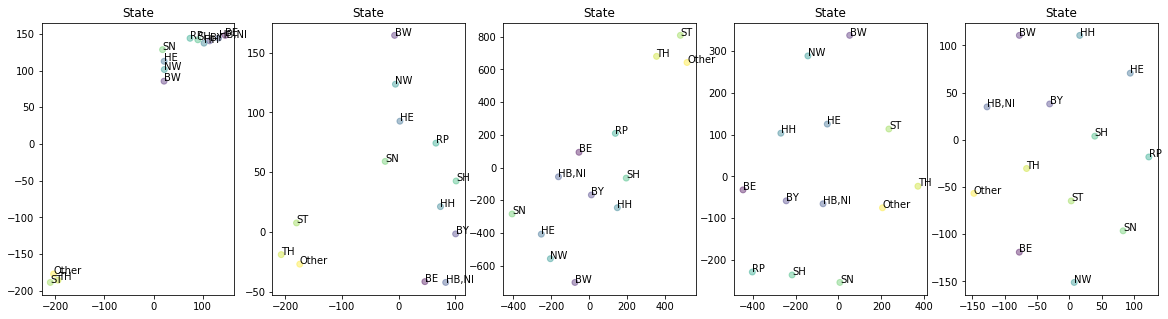

In [24]:
#Example: for the State embedding (idx=13) we plot for different values of Perplexities

Perplexities = [2,4,5,10,25]

fig, axes = plt.subplots(nrows=1,ncols=len(Perplexities))
fig.set_figheight(5)
fig.set_figwidth(20)
for i,per in enumerate(Perplexities):
    idx2EmbPlot(13,per,ax=axes[i])


In [26]:
fig.savefig('StateEmbeddings')